<a href="https://colab.research.google.com/github/jecampagne/demo-hopfield-rbm-networks/blob/main/demo_hopfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator
from PIL import Image
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ls ./drive/MyDrive/'Colab Notebooks'/celebA_100

img000000.png  img000017.png  img000034.png  img000051.png  img000068.png  img000085.png
img000001.png  img000018.png  img000035.png  img000052.png  img000069.png  img000086.png
img000002.png  img000019.png  img000036.png  img000053.png  img000070.png  img000087.png
img000003.png  img000020.png  img000037.png  img000054.png  img000071.png  img000088.png
img000004.png  img000021.png  img000038.png  img000055.png  img000072.png  img000089.png
img000005.png  img000022.png  img000039.png  img000056.png  img000073.png  img000090.png
img000006.png  img000023.png  img000040.png  img000057.png  img000074.png  img000091.png
img000007.png  img000024.png  img000041.png  img000058.png  img000075.png  img000092.png
img000008.png  img000025.png  img000042.png  img000059.png  img000076.png  img000093.png
img000009.png  img000026.png  img000043.png  img000060.png  img000077.png  img000094.png
img000010.png  img000027.png  img000044.png  img000061.png  img000078.png  img000095.png
img000011.png  img000

In [2]:
def hebb_learning(xi):
    n = xi.shape[0] # number of patterns
    if len(xi.shape) == 1:
        #vector
        w = np.outer(xi,xi)/n
    elif len(xi.shape) == 2:
        # matrix
        w = np.einsum("ik,jk",xi,xi)/n
    else:
        print("Error: hebb_mxt xi.shape>2")

    np.fill_diagonal(w,0) # wii=0
    return w

def sign_0(array): #fonction signe
    return np.where(array >= -1e-15,1,-1)

def sigmoid(z):
    return 1/(1 + np.exp(-z))


In [3]:
def perceptron_learning(xi, nIter=1, lr=0.01, alpha=0.01, beta=1.0):
    w = hebb_learning(xi) # init
    ti = np.where(xi==-1.,0.,xi)  # -1->0  ti:{0,1}
    for i in range(nIter):
        print(">>>>> Loop: ",i)
#        print("w min/max:",np.min(w),np.max(w))
        np.fill_diagonal(w,0.)   # garantie que wii=0
        a = np.einsum("ij,jp",w,xi) # calcul de ttes les activations
#        print("a shape:",a.shape,"\n",a)
        y=sigmoid(beta*a)             # sigmoid output  avec beta=1/T
#        print("y shape:",y.shape,"\n",y)
        e = ti-y                 # error
#        print("e shape:",e.shape,"\n",e)
        gw = np.einsum("ip,jp",e,xi)  # compute gradiant
#        print("gw shape:",gw.shape,"\n",gw)
        gw = gw+gw.T             # dwij = dwji
        dw = lr*(gw - alpha*w)   # weight update learning rate + weight decay
#        print("dw min/max:",np.min(dw),np.max(dw))
        w += dw
    return w

In [4]:
class HopFieldNet:
    def __init__(self, N=100, nIter=10, lr=0.01, alpha=0.01, beta=1.0):
        self.init_new(N) # nombre de neurones
        # parametres pour perceptron learning
        self.nIter = nIter  # nbre d'iterations
        self.lr    = lr     # learning rate descente de gradient
        self.alpha = alpha  # weight decay qui simule la regularisaion L2
        self.beta  = beta   # inverse de la temperature de la sigmoid

    def init_new(self, N):
        self.N = N             # number of neurons
        self.w = np.zeros((N,N), dtype="float64") # weight matrix
        # notice that wii=0, wij=wji so sparse mtx would be better
        self.S = -1 * np.ones(N, dtype="float64") # neuron states
        self.xi= np.empty((N,0), dtype="float64") # saved pattern
        self.p = 0 # number of saved pattern
        self.t = 0 # iteraction index

    def set_initial_neuron_states(self, S_init):
        self.t = 0  # reset timer
        self.S = np.copy(S_init)

    def weight_learning(self, input_patterns):
        self.w = perceptron_learning(input_patterns,
                            nIter=self.nIter,
                            lr=self.lr,
                            alpha=self.alpha,
                            beta=self.beta)
        self.xi = input_patterns
        self.p  = self.xi.shape[1]


    def weight_update(self, input_pattern):
        self.w += hebb_learning(input_pattern)
        self.xi = np.column_stack((self.xi, input_pattern))
        self.p  = self.xi.shape[1]

    def remove_pattern(self, i):
        if i < self.p:
            self.w -= construct_hebb_matrix(self.xi[:, i])
            self.xi = np.delete(self.xi, i, axis=1)
            self.p = self.xi.shape[1]
        else:
            print("There is no pattern to remove!")

    def neuron_update(self, iterations, run_max=False):
        self.t += iterations
        #mode asynchrone
        for _ in range(iterations):
            for i in np.random.permutation(self.N):
                self.S[i] = sign_0(np.dot(self.w[i,:], self.S))
        if run_max:
            while true:
                last_S = np.copy(self.S)
                for i in np.random.permutation(self.N):
                    self.S[i] = sign_0(np.dot(self.w[i,:], self.S))
                if np.array_equal(last_S, self.S):
                    return
                self.t += 1

    def neuron_update_beta(self, iterations):
        self.t += iterations
        #mode asynchrone
        for _ in range(iterations):
            for i in np.random.permutation(self.N):
                self.S[i] = (
                    2
                    * (
                        1/(1+np.exp(-2 * beta * np.dot(self.w[i,:], self.S)))
                        >= np.random.rand(1)
                    )
                    -1
                )

    def check_stability(self, S):
        # test if S is stable up on network neuron activation
        return np.array_equal(S, sign_0(np.dot(self.w, self.S)))

    def check_hamm_stability(self, S):
        return hamming_distance(S, sign_0(np.dot(self.w, self.S)))



In [5]:
def print_img(img,ax=None):
    if ax is None:
        fig, ax=plt.subplots(1,1)
    n = img.shape[0]
    if len(img.shape) == 1:
        n=int(np.sqrt(n))
        ax.matshow(img.reshape(n,-1),cmap='Greys')
        ax.set_xticks([])
        ax.set_yticks([])
    elif len(img.shape) ==2:
        ax.matshow(img,cmap='Greys')
        ax.set_xticks([])
        ax.set_yticks([])

In [6]:
def hamming_distance(x, y):
    return np.sum(x != y)

In [7]:
def plot_network_development(
    network, timesteps, exact_state,
    outputpath=".",
    anno_hamming=True
):
    fig, axarr = plt.subplots(1, timesteps)
    fig.set_size_inches(4 * timesteps, 4)
    N_sqrt = int(np.sqrt(network.N))
    for t in range(timesteps):
        axarr[t].imshow(
            np.copy(network.S.reshape((N_sqrt, N_sqrt))),
            cmap="Greys",
            vmin=-1,
            vmax=+1,
            interpolation="none",
        )
        axarr[t].get_xaxis().set_visible(False)
        axarr[t].get_yaxis().set_visible(False)
        hd = hamming_distance(exact_state, network.S)
        if anno_hamming:
            axarr[t].set_title("t = {}, hamming distance = {}".format(t, hd))
            fig.tight_layout()
        else:
            axarr[t].set_title("t = {}".format(t), fontsize=32)
        network.neuron_update(1)
    fig.savefig(outputpath)

In [8]:
def image2numpy_array(path, size):
    img_pil = Image.open(path)
    img_pil = img_pil.resize(size)
    img_pil = img_pil.convert("1")  # convert image to black and white
    img_np = np.zeros(img_pil.size, dtype="uint8")
    for i in range(img_pil.size[0]):
        for j in range(img_pil.size[1]):
            img_np[i, j] = img_pil.getpixel((i, j))
    img_np = np.where(img_np <= 0, 1, -1)
    return img_np.transpose()

def images2xi(path_vec, N):
    p = len(path_vec)
    xi = np.empty((N, p), dtype="int8")  # array with saved patterns
    N_sqrt = int(np.sqrt(N))
    for i, filename in enumerate(path_vec):
        xi[:, i] = image2numpy_array(filename, (N_sqrt, N_sqrt)).flatten()
    return xi


In [9]:
def check_global_stability(net):
    p = net.p
    #    print("Number of patterns: ",p)
    for ip in range(p):
        exact_state = np.copy(net.xi[:,ip])
        net.set_initial_neuron_states(exact_state)
        if not net.check_stability(exact_state):
            print("network un-stable for at least pattern:",ip)
            print_img(exact_state)
            return
    print("stab test Ok")


def check_global_hamm(net):
    p = net.p
#    print("Number of patterns: ",p)
    data = []
    for ip in range(p):
        exact_state = np.copy(net.xi[:,ip])
        net.set_initial_neuron_states(exact_state)
        data.append(net.check_hamm_stability(exact_state))
    return data

In [10]:
def listdir_fullpath(basepath):
    return sorted([os.path.join(basepath,file) for file in os.listdir(basepath) if not os.path.isdir(os.path.join(basepath, file))])

In [11]:
def gener_pattern(N):
    return 2*np.random.randint(2, size=N)-1

# Test : face images 100x100 from CelebA

In [14]:
pathvec_all = np.array(listdir_fullpath("./drive/MyDrive/Colab Notebooks/celebA_100"))

In [15]:
from numpy.random import default_rng
n_pat = 6

rng = default_rng(42) #seed
indices = rng.choice(len(pathvec_all), size=n_pat, replace=False)

In [16]:
N=100**2 # number of neurons = 100x100
xi = images2xi(pathvec_all[indices],N) # transform images to patterns

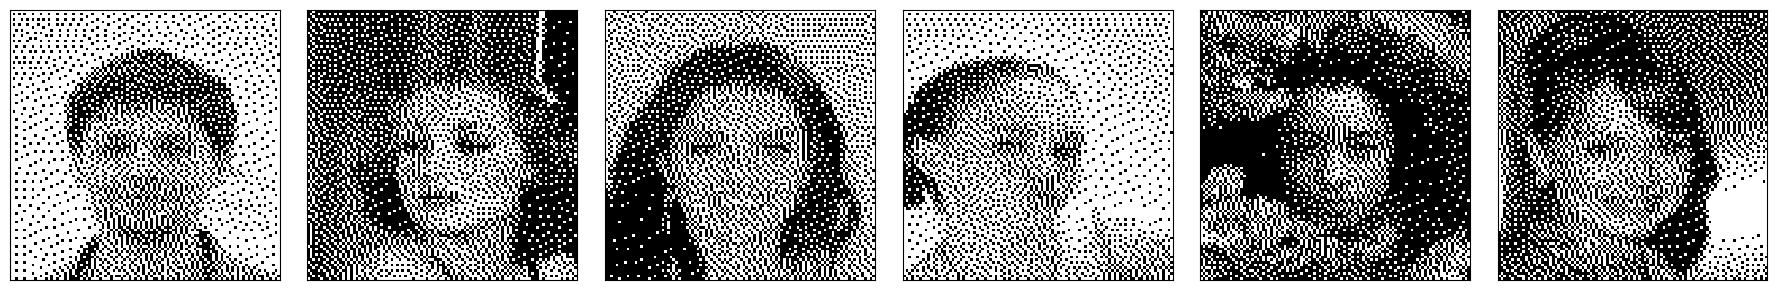

In [17]:
# show the original binarized images
ncol = 6
nrow = 1
fig,ax = plt.subplots(nrow,ncol,figsize=(ncol*3,nrow*3))
ax = ax.ravel()
for idx in range(n_pat):
    i=idx//ncol
    j=idx%ncol
    print_img(xi[:,idx],ax=ax[j+ncol*i])
fig.tight_layout()

In [18]:
# init Hopfield net with N neurons (N/(N-1)/2 weights set to 0)
bignet = HopFieldNet(N=N)

In [19]:
# Make a single weights update with Hebb rule
bignet.weight_update(xi)

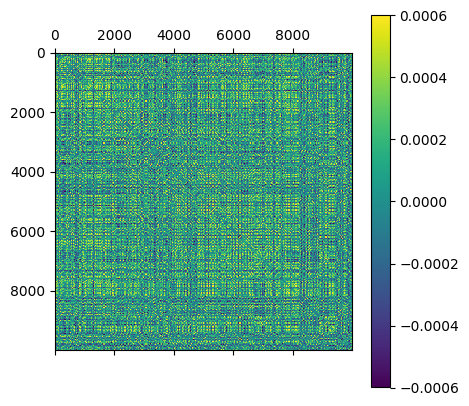

In [20]:
# show the weight matrix
plt.matshow(bignet.w);plt.colorbar();

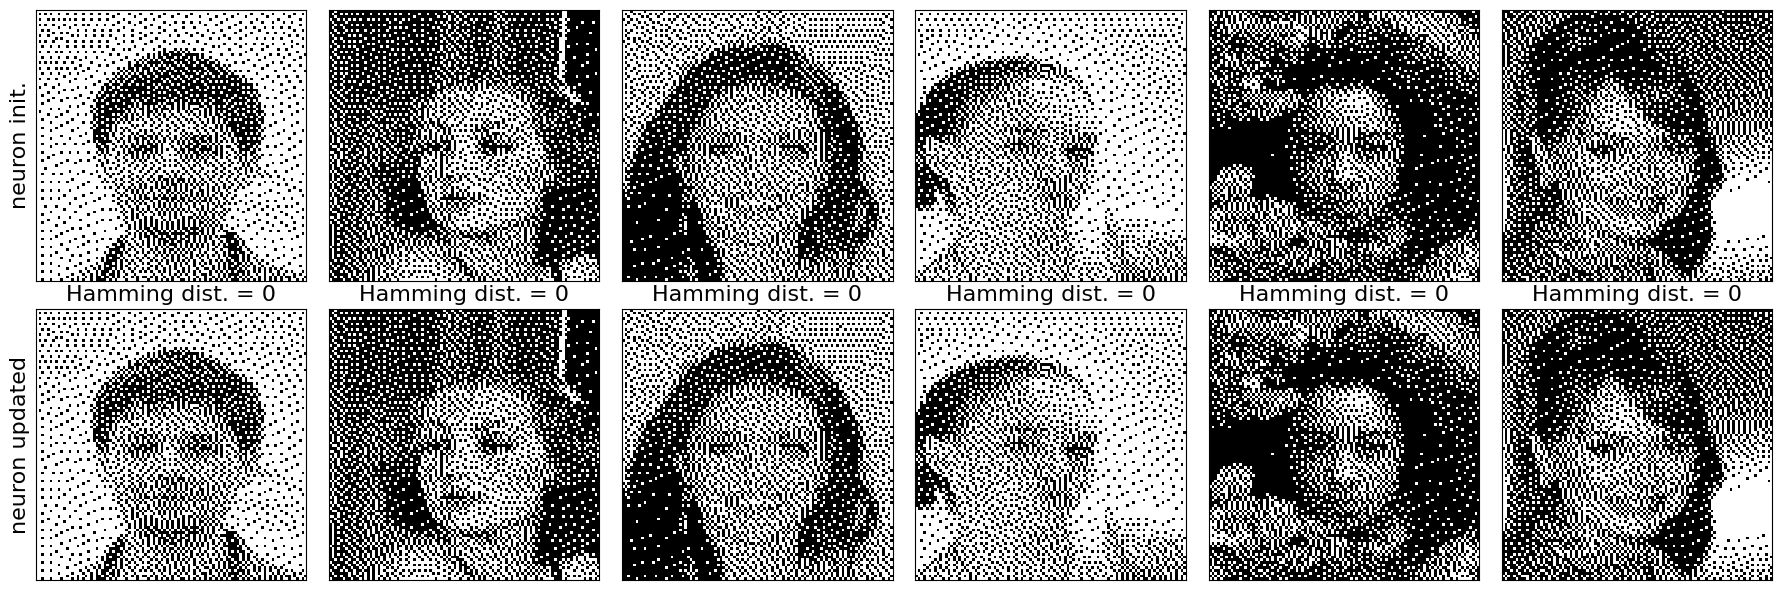

In [71]:
#Show that all the 10 patterns are stable after neurons update

ncol = 6
nrow = 2*1
fig,ax = plt.subplots(nrow,ncol,figsize=(ncol*3,nrow*3))

for idx in range(n_pat):
    i=idx//ncol
    j=idx%ncol
    print_img(xi[:,idx],ax=ax[2*i,j])
    if j==0:
      ax[2*i,j].set_ylabel("neuron init.",fontsize=16)
    bignet.set_initial_neuron_states(xi[:,idx])
    bignet.neuron_update(1)
    print_img(bignet.S,ax=ax[2*i+1,j])
    if j==0:
      ax[2*i+1,j].set_ylabel("neuron updated",fontsize=16)
    hd = hamming_distance(xi[:,idx], bignet.S)
    ax[2*i+1,j].set_title(f"Hamming dist. = {hd}",fontsize=16)
fig.tight_layout()
fig.savefig("fig-hopfield-6imgs-stable.png")

In [22]:
check_global_stability(bignet)

stab test Ok


## Set 50% of the weights to 0 and see if the partern are still stable

In [23]:
tmp = bignet.w.copy()

In [24]:
tmp.shape

(10000, 10000)

In [31]:
U = tmp[np.triu_indices(tmp.shape[0], k = 0)]

In [33]:
mask = np.random.binomial(1, 0.5, size=(len(U),))

In [34]:
U_mod = np.multiply(U,mask)

In [35]:
tmp_new = np.zeros_like(tmp)

In [36]:
tmp_new[np.triu_indices(tmp.shape[0], k = 0)] = U_mod

In [40]:
tmp_new = tmp_new + tmp_new.T

In [46]:
bignet.w = tmp_new

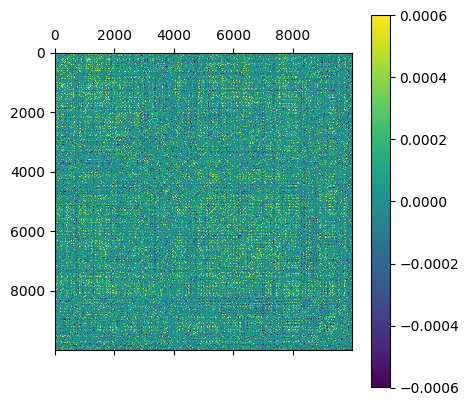

In [42]:
plt.matshow(bignet.w);plt.colorbar();

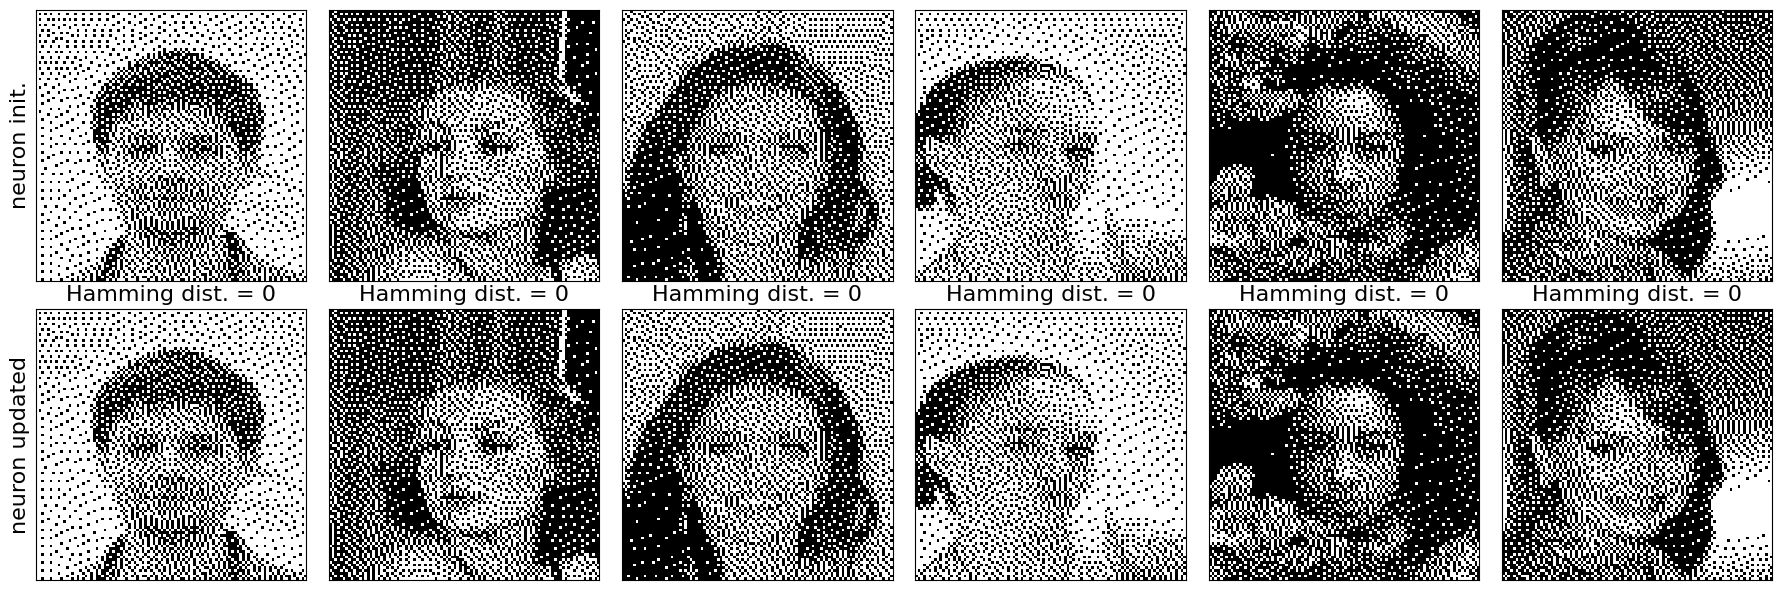

In [45]:
ncol = 6
nrow = 2*1
fig,ax = plt.subplots(nrow,ncol,figsize=(ncol*3,nrow*3))

for idx in range(n_pat):
    i=idx//ncol
    j=idx%ncol
    print_img(xi[:,idx],ax=ax[2*i,j])
    if j==0:
      ax[2*i,j].set_ylabel("neuron init.",fontsize=16)
    bignet.set_initial_neuron_states(xi[:,idx])
    bignet.neuron_update(1)
    print_img(bignet.S,ax=ax[2*i+1,j])
    if j==0:
      ax[2*i+1,j].set_ylabel("neuron updated",fontsize=16)
    hd = hamming_distance(xi[:,idx], bignet.S)
    ax[2*i+1,j].set_title(f"Hamming dist. = {hd}",fontsize=16)
fig.tight_layout()

## get back the original weights

In [47]:
bignet.w =tmp

In [50]:
check_global_stability(bignet)

stab test Ok


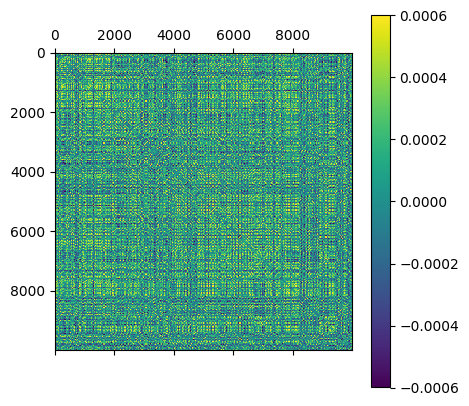

In [48]:
plt.matshow(bignet.w);plt.colorbar();

## Set to zero 99.7% of a pattern pxelx and feed to the network input and let see the attraction towards the original pattern

In [97]:
np.random.seed(123)
idx=np.random.randint(0,n_pat,1)
exact_state = np.copy(xi[:,idx]).squeeze()
bignet.set_initial_neuron_states(exact_state)
bignet.check_stability(exact_state)

True

In [98]:
i=99.7
arr = random.sample(range(1, N), int(N*i/100.))
S_init = np.copy(exact_state)
S_init[arr] = 0

In [99]:
bignet.set_initial_neuron_states(S_init)  # init with the degraded image
bignet.neuron_update(1)                   # update the neurons once

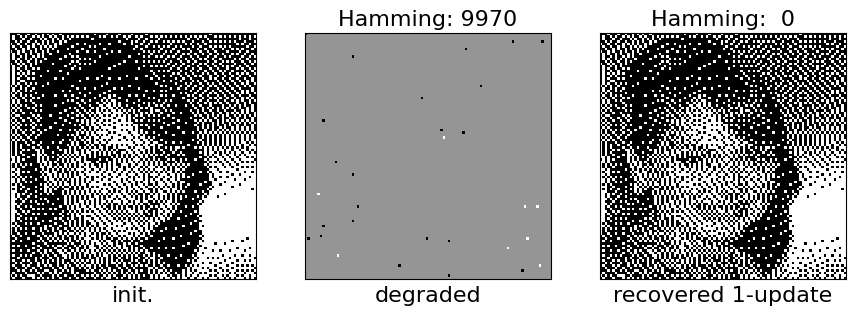

In [100]:
fig,axs = plt.subplots(1,3,figsize=(3*3,1*3))
print_img(exact_state,axs[0])
axs[0].set_xlabel("init.",fontsize=16)
print_img(S_init,axs[1])
axs[1].set_title(f"Hamming: {hamming_distance(exact_state,S_init)}",fontsize=16)
axs[1].set_xlabel(f"degraded",fontsize=16)
print_img(bignet.S,axs[2])
axs[2].set_title(f"Hamming:  {hamming_distance(exact_state,bignet.S)}",fontsize=16);
axs[2].set_xlabel(f"recovered 1-update",fontsize=16);
fig.tight_layout()
fig.savefig("fig-hopfield-recover_1.png")

## Flip 48% of pixels of a pattern

In [140]:
np.random.seed(123)
S_init = np.copy(exact_state)
arr = random.sample(range(1, N), int(N*48/100.))
S_init = np.copy(exact_state)
S_init[arr] *= -1

In [121]:
bignet.set_initial_neuron_states(S_init)  # init with the degraded image
bignet.neuron_update(1)                   # update the neurons once
S_state_1 = bignet.S

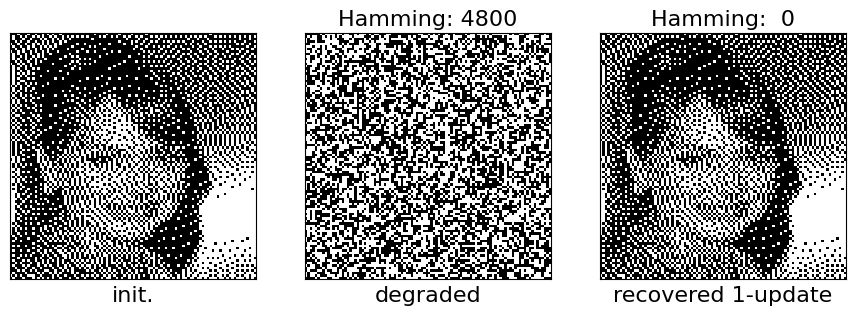

In [122]:
fig,axs = plt.subplots(1,3,figsize=(3*3,1*3))
print_img(exact_state,axs[0])
axs[0].set_xlabel("init.",fontsize=16)
print_img(S_init,axs[1])
axs[1].set_title(f"Hamming: {hamming_distance(exact_state,S_init)}",fontsize=16)
axs[1].set_xlabel(f"degraded",fontsize=16)
print_img(S_state_1,axs[2])
axs[2].set_title(f"Hamming:  {hamming_distance(exact_state,S_state_1)}",fontsize=16);
axs[2].set_xlabel(f"recovered 1-update",fontsize=16);
fig.tight_layout()
fig.savefig("fig-hopfield-recover_2.png")

# Add more faces....

In [124]:
xi2 = images2xi(pathvec_all,N)

In [125]:
xi2.shape

(10000, 100)

In [132]:
bignet2 = HopFieldNet(N=10000)

In [133]:
info = []
for i in range(50):
    bignet2.weight_update(xi2[:,i])
    p = bignet2.p
    nfalse = np.count_nonzero(check_global_hamm(bignet2))
    info.append([p,nfalse/p])
info = np.array(info)

In [134]:
info.shape

(50, 2)

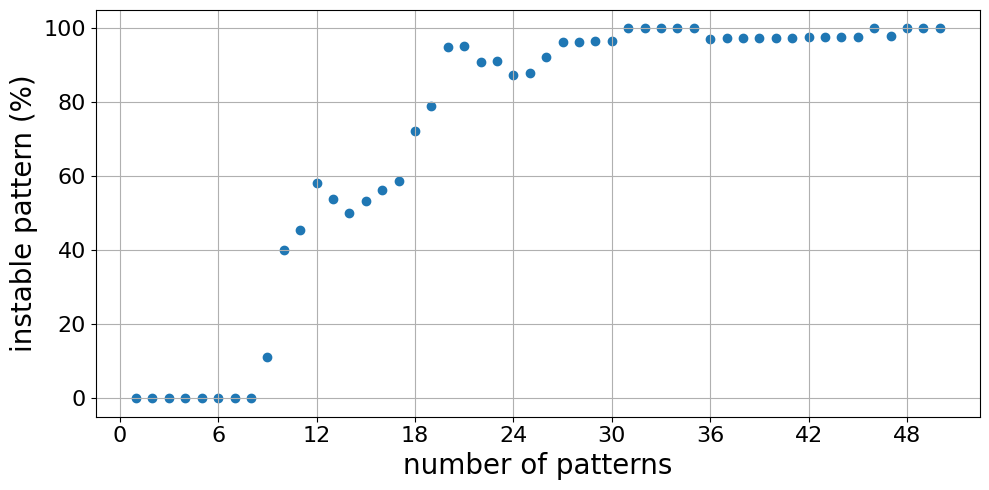

In [137]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(info[:,0],info[:,1]*100)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.set_xlabel('number of patterns',fontsize=20)
ax.set_ylabel('instable pattern (%)',fontsize=20);
fig.tight_layout()
fig.savefig("fig-hopfield-instable-pattern.pdf")

# Use random (Rademacher) patterns

In [16]:
N=10_000   # number of neurons
bignet2 = HopFieldNet(N=N)
bs=1
np.random.seed(123)
all_pat = gener_pattern(600*N)   # 1000 x number of neurons in the Networs

In [17]:
info = []
for i in range(all_pat.size//(N*bs)):
    if i%50==0:
      print("i=",i)
    new_pat = all_pat[i*bs*N:(i+1)*bs*N]
    bignet2.weight_update(new_pat)
    p = bignet2.p
    nfalse = np.count_nonzero(check_global_hamm(bignet2))
    info.append([p,nfalse/p])
info = np.array(info)

i= 0
i= 50
i= 100
i= 150
i= 200
i= 250
i= 300
i= 350
i= 400
i= 450
i= 500
i= 550


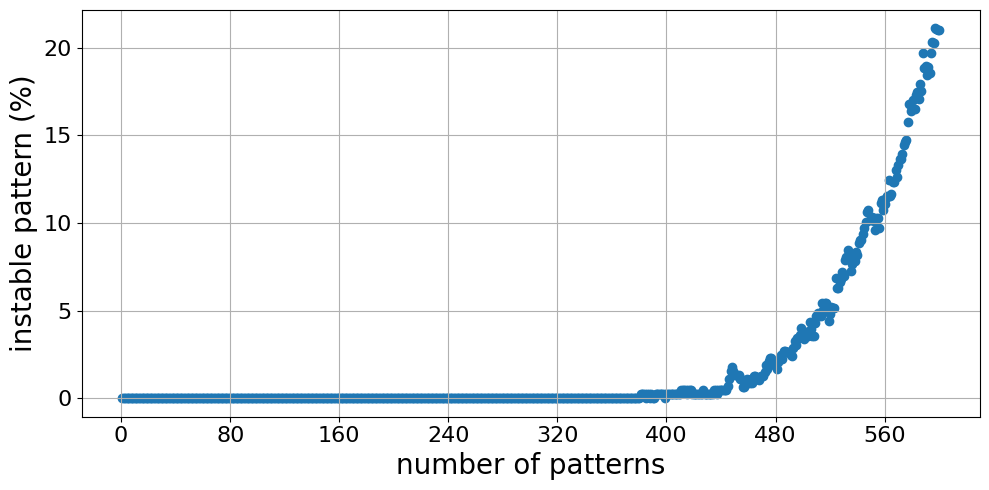

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(info[:,0],info[:,1]*100)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.set_xlabel('number of patterns',fontsize=20)
ax.set_ylabel('instable pattern (%)',fontsize=20);
fig.tight_layout()
fig.savefig("fig-hopfield-instable-random-pattern.pdf")

# Test : 6 patterns 5x5  comapre Hebb and Perception learning methods

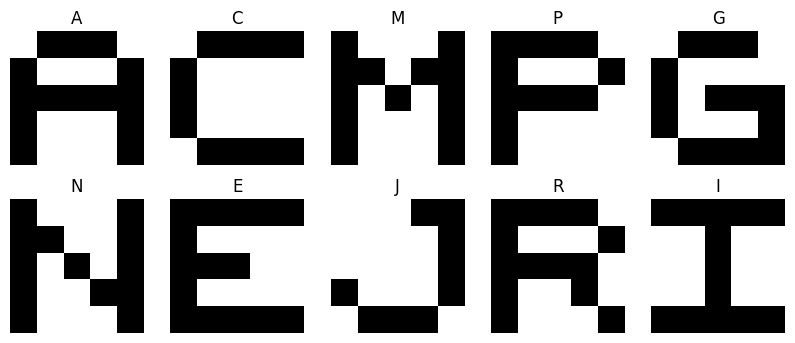

In [18]:
# Création des matrices pour chaque lettre
letters_matrices = {
    "A": np.array([
        [-1,  1,  1,  1, -1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1, -1, -1, -1,  1]
    ],dtype="float64").reshape(-1),
    "C": np.array([
        [-1,  1,  1,  1,  1],
        [ 1, -1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [-1,  1,  1,  1,  1]
    ],dtype="float64").reshape(-1),
    "M": np.array([
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1,  1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1, -1, -1, -1,  1]
    ],dtype="float64").reshape(-1),
    "P": np.array([
        [ 1,  1,  1,  1, -1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1,  1,  1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1, -1, -1, -1, -1]
    ],dtype="float64").reshape(-1),
    "G": np.array([
        [-1,  1,  1,  1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1, -1,  1,  1,  1],
        [ 1, -1, -1, -1,  1],
        [-1,  1,  1,  1,  1]
    ],dtype="float64").reshape(-1),
    "N": np.array([
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1, -1, -1, -1,  1]
    ],dtype="float64").reshape(-1),
    "E": np.array([
        [ 1,  1,  1,  1,  1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1]
    ],dtype="float64").reshape(-1),
    "J": np.array([
        [-1, -1, -1,  1,  1],
        [ -1, -1, -1, -1,  1],
        [ -1, -1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [-1,  1,  1,  1, -1]
    ],dtype="float64").reshape(-1),
    "R": np.array([
        [ 1,  1,  1,  1, -1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1,  1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1, -1, -1, -1,  1]
    ],dtype="float64").reshape(-1),
    "I": np.array([
        [ 1,  1,  1,  1,  1],
        [-1, -1,  1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1, -1,  1, -1, -1],
        [ 1,  1,  1,  1,  1]
    ],dtype="float64").reshape(-1),
}

# Affichage de chaque matrice sous forme d'image
fig, axs = plt.subplots(2, 5, figsize=(5*2, 2*2))

for ax, (letter, matrix) in zip(axs.ravel(), letters_matrices.items()):
    ax.imshow(matrix.reshape((5,5)), cmap='Greys')
    ax.set_title(letter)
    ax.axis('off')


In [76]:
np.random.seed(1)
indices = np.random.choice(10,6,replace=False)
letters = np.array(list(letters_matrices.keys()))
pattern_letters = letters[indices]
# build patterns array
all_pats = letters_matrices[pattern_letters[0]]
for i in range(1,len(pattern_letters)):
  all_pats =  np.column_stack((all_pats,letters_matrices[pattern_letters[i]] ))

In [77]:
# Hopfield network with Hebb learning
net = HopFieldNet(N=25)
net.weight_update(all_pats)

# Hopfield network with perceptron learning
net2 = HopFieldNet(N=25, nIter=10,lr=0.01, alpha=0.01,beta=1.4)
net2.weight_learning(all_pats)

>>>>> Loop:  0
>>>>> Loop:  1
>>>>> Loop:  2
>>>>> Loop:  3
>>>>> Loop:  4
>>>>> Loop:  5
>>>>> Loop:  6
>>>>> Loop:  7
>>>>> Loop:  8
>>>>> Loop:  9


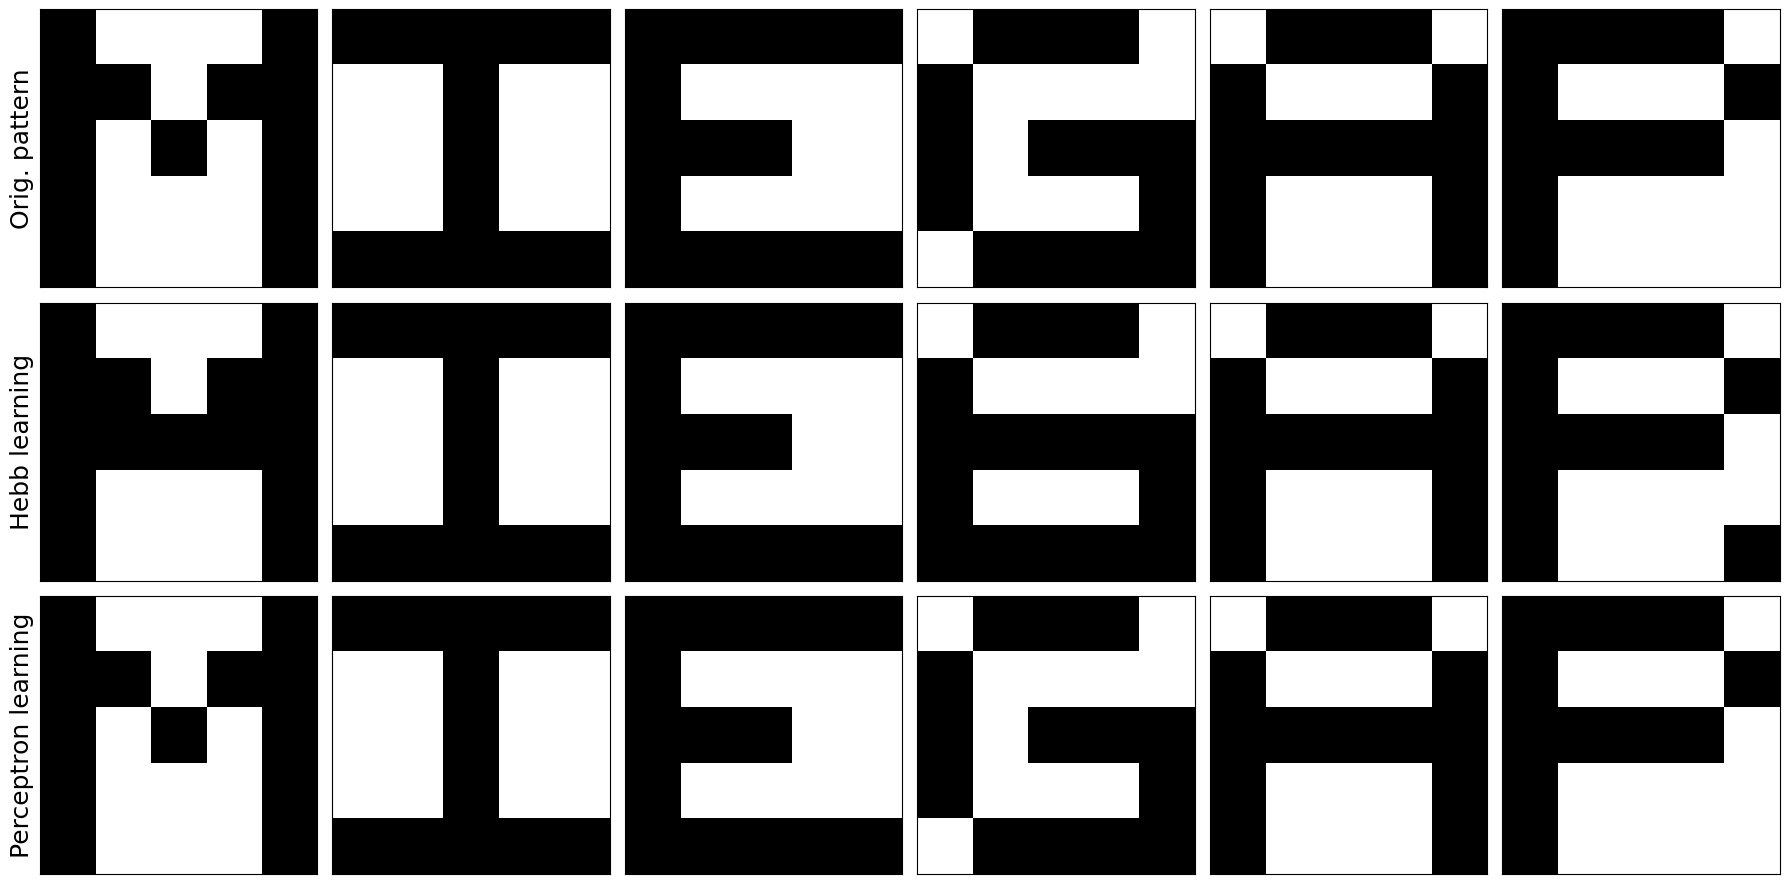

In [80]:
Npat = all_pats.shape[1]
fig,ax = plt.subplots(3,Npat,figsize=(Npat*3,3*3))
for ipat in range(Npat):
    # original pattern
    print_img(all_pats[:,ipat],ax=ax[0,ipat])
    #ax[0,ipat].axis("off")
    if ipat == 0:
      ax[0,ipat].set_ylabel("Orig. pattern",fontsize=18)

    # Hebb update of network
    net.set_initial_neuron_states(all_pats[:,ipat])
    net.neuron_update(1)
    print_img(net.S,ax=ax[1,ipat])
    if ipat == 0:
      ax[1,ipat].set_ylabel("Hebb learning",fontsize=18)
    #ax[1,ipat].axis("off")

    # Perceptron update of network
    net2.set_initial_neuron_states(all_pats[:,ipat])
    net2.neuron_update(1)
    print_img(net2.S,ax=ax[2,ipat])
    if ipat == 0:
      ax[2,ipat].set_ylabel("Perceptron learning",fontsize=18)
    #ax[2,ipat].axis("off")

plt.tight_layout()
fig.savefig("fig-hopfield-Hebb-Perceptron.png")